### Import Library

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# scaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)

# Models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Data

In [175]:
# Load data
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")
X = rumah123_df.drop(columns=["price"])
y = rumah123_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Preprocessing

In [176]:
# Inisialisasi dan fit TargetEncoder hanya pada train
encoder = TargetEncoder(cols=["location"])
encoder.fit(X_train, y_train)

# Transformasi train dan test
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [177]:
# Normalisasi dengan MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

### Modeling

In [178]:
best_params = {
    "colsample_bytree": 0.8,
    "learning_rate": 0.03,
    "max_depth": 9,
    "n_estimators": 500,
    "subsample": 0.8,
    "verbosity": 0,
    "random_state": 42,
    }

# best_params = {'subsample': 0.7, 'reg_lambda': 0.1, 
#                 'reg_alpha': 1, 'n_estimators': 1000, 
#                 'min_child_weight': 1, 'max_depth': 9, 
#                 'learning_rate': 0.01, 'gamma': 0.3, 
#                 'colsample_bytree': 0.9, "random_state": 42}

model = XGBRegressor(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred

array([1126.7834 ,  869.6218 ,  922.96936, ...,  565.1714 , 1330.8657 ,
       1913.1694 ], dtype=float32)

### Scatter Plot Fact VS Predict and Best Fit VS Identity

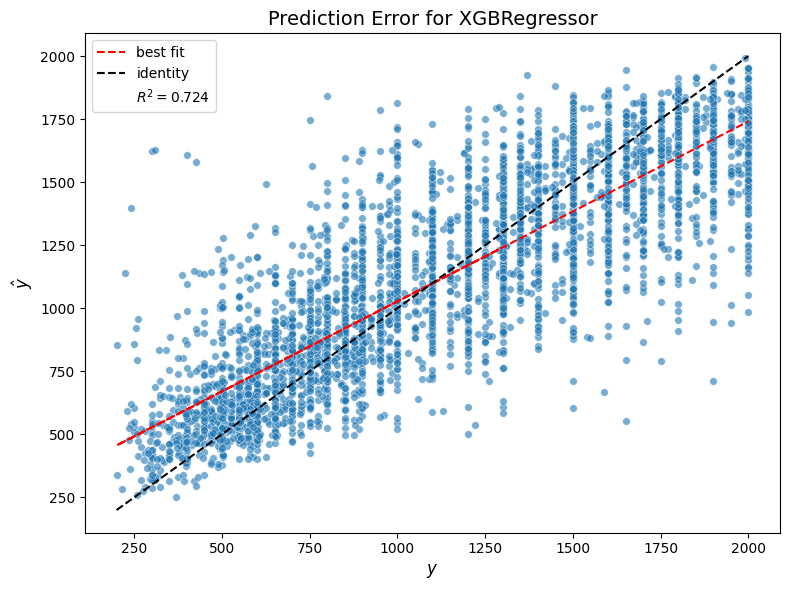

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Hitung R^2
r2 = r2_score(y_test, y_pred)

# Best fit line
model_fit = LinearRegression()
model_fit.fit(y_test.values.reshape(-1, 1), y_pred)
y_fit_line = model_fit.predict(y_test.values.reshape(-1, 1))

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, s=30, alpha=0.6)

# Plot garis best fit
plt.plot(y_test, y_fit_line, color='red', linestyle='--', label='best fit')

# Plot garis identitas (y = ŷ)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, color='black', linestyle='--', label='identity')

# Label dan judul
plt.xlabel('$y$', fontsize=12)
plt.ylabel(r'$\hat{y}$', fontsize=12)
plt.title('Prediction Error for XGBRegressor', fontsize=14)

# Tambahkan R^2 ke dalam label legenda
plt.plot([], [], ' ', label=f'$R^2 = {r2:.3f}$')

plt.legend()
plt.tight_layout()
plt.show()

In [180]:
lims

[200, 2000]

In [181]:
y_fit_line

array([1234.10631993,  870.07146446,  991.41641628, ...,  670.20919086,
       1312.6236417 , 1740.89994227])

In [182]:
import json

# Konversi ke tipe data Python standar
data_to_save = {
    'identity_line': [int(x) for x in lims],                # list of float
    'y_pred': y_pred.astype(float).tolist(),                # array → list of float
    'y_test': y_test.astype(int).tolist(),                  # Series → list of float
    'y_fit_line': y_fit_line.astype(float).tolist(),        # array → list of float
    'r2': float(r2)                                         # float
}

# Simpan ke file JSON
with open('../../data/visualisation/distribution_predict.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)


### Scatter Plot Residuals and Bar Chart Distribution Residuals

C:\Users\munaf\AppData\Local\Temp\ipykernel_13628\1188923893.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


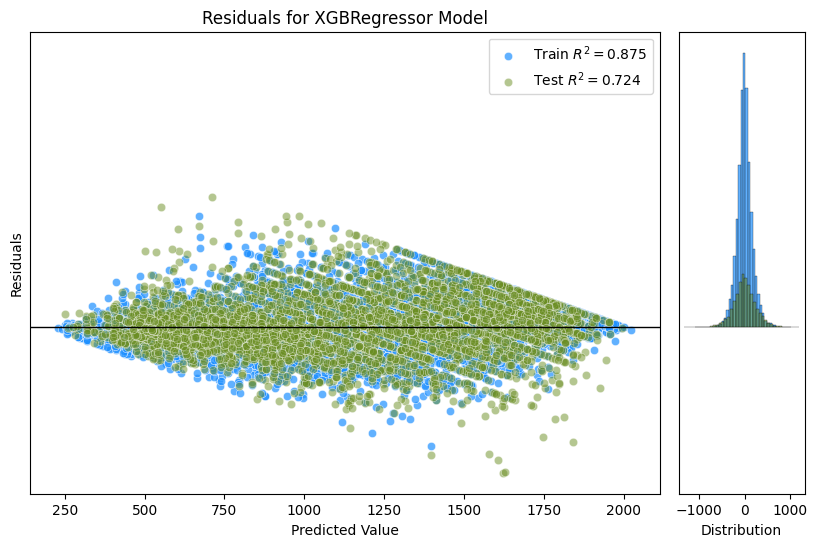

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Asumsikan sudah ada data:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Hitung residual
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Hitung R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Setup figure
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 2, width_ratios=(5, 1), wspace=0.05)
ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1], sharey=ax)

# Plot scatter residuals
sns.scatterplot(x=y_train_pred, y=residuals_train, color='dodgerblue', alpha=0.7, ax=ax, label=fr'Train $R^2 = {r2_train:.3f}$')
sns.scatterplot(x=y_test_pred, y=residuals_test, color='olivedrab', alpha=0.5, ax=ax, label=fr'Test $R^2 = {r2_test:.3f}$')

# Horizontal zero line
ax.axhline(0, color='black', linewidth=1)

# Labels dan judul
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
ax.set_title("Residuals for XGBRegressor Model")
ax.legend()

# Plot histogram distribusi residual
sns.histplot(residuals_train, bins=40, orientation='horizontal', color='dodgerblue', alpha=0.7, ax=ax_hist)
sns.histplot(residuals_test, bins=40, orientation='horizontal', color='olivedrab', alpha=0.5, ax=ax_hist)

ax_hist.set_xlabel("Distribution")
ax_hist.set_ylabel("")
ax_hist.set_yticks([])

plt.tight_layout()
plt.show()

<h3>Analisa R-Square</h3>
Model memiliki kemampuan sangat baik pada data latih, menjelaskan sekitar 87.5% variasi data.

Performanya juga cukup baik pada data uji (72.4%), meskipun ada sedikit penurunan (gap ±0.15) yang masih tergolong wajar sehingga tidak ada indikasi overfitting berlebihan.

<h3>Pola Residual</h3>
Residual tersebar di sekitar garis horizontal nol, yang merupakan indikator baik bahwa model tidak bias secara sistematis. Namun, kesalahan terbesar cenderung terjadi pada harga menengah (sekitar puncak distribusi prediksi). 

Sementara pada harga ekstrem (sangat rendah dan sangat tinggi), residual lebih kecil dan terdistribusi sempit. Namun, masih ada beberapa residual yang cukup jauh dari residual lain di nilai ekstrem

<h3>Distribusi Residual</h3>
Histogram di sisi kanan menunjukkan distribusi residual yang simetris dan terpusat di nol. Hal ini mengindikasikan bahwa sebagian besar prediksi model mendekati nilai sebenarnya. Puncak yang tajam dan simetris menandakan bahwa sebagian besar kesalahan kecil, dan residual ekstrem jarang terjadi.

Distribusi residual pada data training (biru) dan testing (hijau) serupa, yang mengindikasikan generalisasi yang baik.

In [184]:
import json

# Konversi ke tipe data Python standar
data_to_save = {
    'y_train_pred': y_train_pred.astype(float).tolist(),
    'y_test_pred': y_test_pred.astype(int).tolist(),
    'residuals_train': residuals_train.astype(float).tolist(),
    'residuals_test': residuals_test.astype(float).tolist(), 
    'r2_train': float(r2_train),
    'r2_test': float(r2_test)
}

# Simpan ke file JSON
with open('../../data/visualisation/distribution_residual.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)


### Table Model Result

In [185]:
# Hitung metrik
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [186]:
# Buat dict berisi (Train, Test) untuk setiap metrik
metrics = {
    "MAE": (mae_train, mae_test),
    "MSE": (mse_train, mse_test),
    "RMSE": (rmse_train, rmse_test),
    "R²": (r2_train, r2_test),
}
df_eval = pd.DataFrame.from_dict(metrics, orient="index", columns=["Train", "Test"])
display(df_eval)

with open('../../data/visualisation/result_table.json', 'w') as f:
    json.dump(metrics, f, indent=2)

,Train,Test
MAE,125.770434,192.609916
MSE,29170.565509,66480.005819
RMSE,170.793927,257.837169
R²,0.874840,0.723668


### Bar Chart Feature Importance

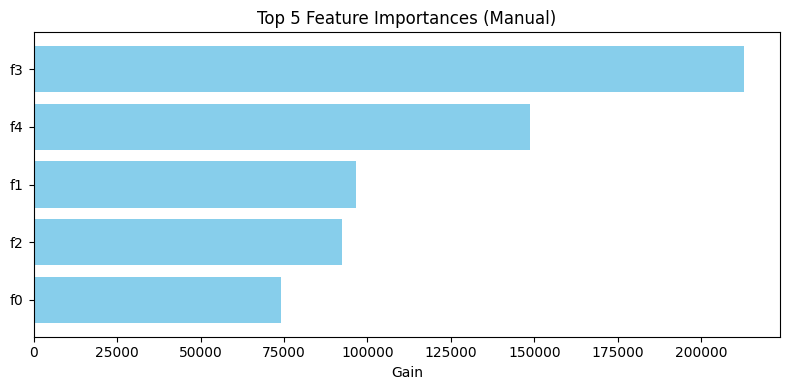

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil importance dari model
importance = model.get_booster().get_score(importance_type='gain')

# Jika feature_names tidak terisi saat training, key akan jadi f0, f1, ...
# Konversi ke DataFrame
imp_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

# Urutkan
imp_df = imp_df.sort_values(by='importance', ascending=False).head(5)

# Plot manual
plt.figure(figsize=(8, 4))
plt.barh(imp_df['feature'], imp_df['importance'], color='skyblue')
plt.xlabel('Gain')
plt.title('Top 5 Feature Importances (Manual)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Prediction Bands / Confidence Intervals

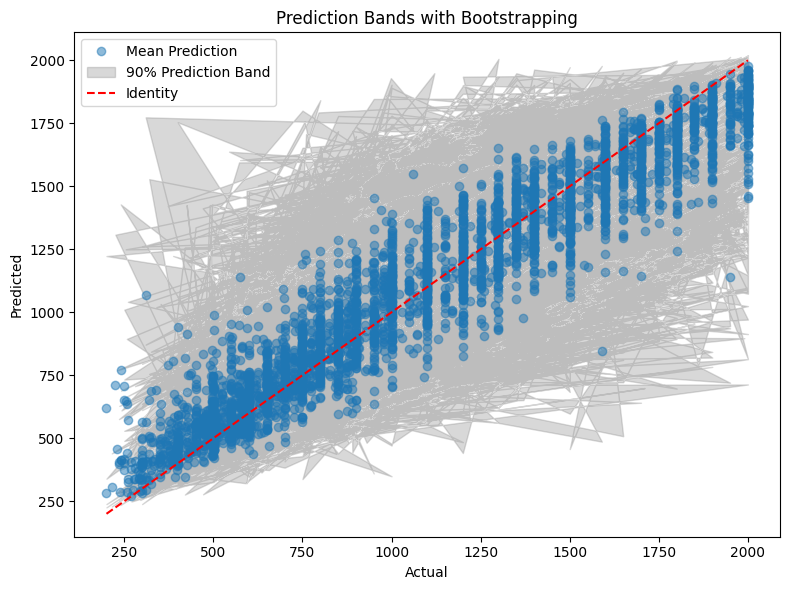

In [189]:
from sklearn.utils import resample

# Bootstrap untuk menghitung prediksi interval
n_bootstraps = 100
bootstrap_preds = []

for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_test_scaled, y_test)
    model.fit(X_sample, y_sample)
    y_boot = model.predict(X_test_scaled)
    bootstrap_preds.append(y_boot)

# Ubah ke array
bootstrap_preds = np.array(bootstrap_preds)

# Hitung lower, upper dan mean
lower = np.percentile(bootstrap_preds, 5, axis=0)
upper = np.percentile(bootstrap_preds, 95, axis=0)
mean_pred = np.mean(bootstrap_preds, axis=0)

# Plot prediction bands
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, mean_pred, 'o', alpha=0.5, label='Mean Prediction')
plt.fill_between(y_test.values, lower, upper, color='gray', alpha=0.3, label='90% Prediction Band')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label='Identity')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Prediction Bands with Bootstrapping')
plt.tight_layout()
plt.show()
